In [3]:
## setup_mnist.py -- mnist data and model loading code
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import tensorflow as tf
import numpy as np
import os
import pickle
import gzip
import urllib.request

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model

def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(num_images*28*28)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data / 255) - 0.5
        data = data.reshape(num_images, 28, 28, 1)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8)
    return (np.arange(10) == labels[:, None]).astype(np.float32)

class MNIST:
    def __init__(self):
        if not os.path.exists("data"):
            os.mkdir("data")
            files = ["train-images-idx3-ubyte.gz",
                     "t10k-images-idx3-ubyte.gz",
                     "train-labels-idx1-ubyte.gz",
                     "t10k-labels-idx1-ubyte.gz"]
            for name in files:

                urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' + name, "data/"+name)

        train_data = extract_data("data/train-images-idx3-ubyte.gz", 60000)
        train_labels = extract_labels("data/train-labels-idx1-ubyte.gz", 60000)
        self.test_data = extract_data("data/t10k-images-idx3-ubyte.gz", 10000)
        self.test_labels = extract_labels("data/t10k-labels-idx1-ubyte.gz", 10000)
        
        VALIDATION_SIZE = 5000
        
        self.validation_data = train_data[:VALIDATION_SIZE, :, :, :]
        self.validation_labels = train_labels[:VALIDATION_SIZE]
        self.train_data = train_data[VALIDATION_SIZE:, :, :, :]
        self.train_labels = train_labels[VALIDATION_SIZE:]


class MNISTModel:
    def __init__(self, restore, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3),
                         input_shape=(28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))
        model.load_weights(restore)

        self.model = model

    def predict(self, data):
        return self.model(data)


In [ ]:
## train_models.py -- train the neural network models for attacking
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.


import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
#from setup_mnist import MNIST
#from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.

    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)
    
if not os.path.isdir('models'):
    os.makedirs('models')

#train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=50)

#train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200], num_epochs=50, train_temp=100)
#train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],num_epochs=50, train_temp=100)


In [ ]:
## verify.py -- check the accuracy of a neural network
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

#from setup_cifar import CIFAR, CIFARModel
#from setup_mnist import MNIST, MNISTModel
#from setup_inception import ImageNet, InceptionModel

import tensorflow as tf
import numpy as np

BATCH_SIZE = 1

with tf.Session() as sess:
    data, model = MNIST(), MNISTModel("models/mnist", sess)
    #data, model = CIFAR(), CIFARModel("models/cifar", sess)
    #data, model = ImageNet(), InceptionModel(sess)

    x = tf.placeholder(tf.float32, (None, model.image_size, model.image_size, model.num_channels))
    y = model.predict(x)

    r = []
    for i in range(0,len(data.test_data),BATCH_SIZE):
        pred = sess.run(y, {x: data.test_data[i:i+BATCH_SIZE]})
        #print(pred)
        #print('real',data.test_labels[i],'pred',np.argmax(pred))
        r.append(np.argmax(pred,1) == np.argmax(data.test_labels[i:i+BATCH_SIZE],1))
        print('mean: ',np.mean(r))


In [8]:
## l2_attack.py -- attack a network optimizing for l_2 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import sys
import tensorflow as tf
import numpy as np

BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class CarliniL2:
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 binary_search_steps = BINARY_SEARCH_STEPS, max_iterations = MAX_ITERATIONS,
                 abort_early = ABORT_EARLY, 
                 initial_const = INITIAL_CONST,
                 boxmin = -0.5, boxmax = 0.5):
        """
        The L_2 optimized attack. 

        This attack is the most efficient and should be used as the primary 
        attack to evaluate potential defenses.

        Returns adversarial examples for the supplied model.

        - confidence: Confidence of adversarial examples: higher produces examples
          that are farther away, but more strongly classified as adversarial.
        - batch_size: Number of attacks to run simultaneously.
          targeted: True if we should perform a targetted attack, False otherwise.
        - learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        - binary_search_steps: The number of times we perform binary search to
          find the optimal tradeoff-constant between distance and confidence. 
        - max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        - abort_early: If true, allows early aborts if gradient descent gets stuck.
        - initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. If binary_search_steps is large,
          the initial constant is not important.
        - boxmin: Minimum pixel value (default -0.5).
        - boxmax: Maximum pixel value (default 0.5).
        """

        image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

        shape = (batch_size,image_size,image_size,num_channels)
        
        # the variable we're going to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        # these are variables to be more efficient in sending data to tf
        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)

        # and here's what we use to assign them
        self.assign_timg = tf.placeholder(tf.float32, shape)
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))
        self.assign_const = tf.placeholder(tf.float32, [batch_size])
        
        # the resulting image, tanh'd to keep bounded from boxmin to boxmax
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus
        
        # prediction BEFORE-SOFTMAX of the model
        self.output = model.predict(self.newimg)
        
        # distance to the input data
        self.l2dist = tf.reduce_sum(tf.square(self.newimg-(tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other-real+self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real-other+self.CONFIDENCE)

        # sum up the losses
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1+self.loss2
        
        # Setup the adam optimizer and keep track of variables we're creating
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        # these are the variables to initialize when we run
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    def attack(self, imgs, targets):
        """
        Perform the L_2 attack on the given images for the given targets.

        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

    def attack_batch(self, imgs, labs):
        """
        Run the attack on a batch of images and labels.
        """
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y

        batch_size = self.batch_size

        # convert to tanh-space
        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # the best l2, score, and image attack
        o_bestl2 = [1e10]*batch_size
        o_bestscore = [-1]*batch_size
        o_bestattack = [np.zeros(imgs[0].shape)]*batch_size
        
        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print(o_bestl2)
            # completely reset adam's internal state.
            self.sess.run(self.init)
            batch = imgs[:batch_size]
            batchlab = labs[:batch_size]
    
            bestl2 = [1e10]*batch_size
            bestscore = [-1]*batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = np.inf
            for iteration in range(self.MAX_ITERATIONS):
                # perform the attack 
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss, 
                                                         self.l2dist, self.output, 
                                                         self.newimg])

                if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                
                # print out the losses every 10%
                if iteration%(self.MAX_ITERATIONS//10) == 0:
                    print(iteration,self.sess.run((self.loss,self.loss1,self.loss2)))

                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e,(l2,sc,ii) in enumerate(zip(l2s,scores,nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack


In [43]:
## test_attack.py -- sample code to test attack procedure
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import tensorflow as tf
import numpy as np
import time

# from setup_cifar import CIFAR, CIFARModel
# from setup_mnist import MNIST, MNISTModel
# from setup_inception import ImageNet, InceptionModel

# from l2_attack import CarliniL2
# from l0_attack import CarliniL0
# from li_attack import CarliniLi


def show(img):
    """
    Show MNSIT digits in the console.
    """
    remap = "  .*#"+"#"*100
    img = (img.flatten()+.5)*3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.

    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                # data.test_labels.shape[1] will have the number of classes (e.g., 10 for MNIST)
                # range would gives us 0,1,2,3,....9 for MNIST
                seq = range(data.test_labels.shape[1])

            # for every class (e.g., 0 to 9 in MNIST)
            for j in seq:
                # When samples==1, then we will put the image at test_data[0] (because start+i will be 0)
                # to inputs 9 times, i.e., inputs[0] through inputs[8] will contain data.test_data[0].
                # These will serve as the source image. We will be converting this image to adv examples
                # targeting each of the other 9 classes
                # When j == the label of the data.test_data[0]-th image, we skip adding anything to 
                # inputs or targets. 
                
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    print('CONTINUE for j={} label={}'.format(j, np.argmax(data.test_labels[start+i])))
                    continue
                inputs.append(data.test_data[start+i])
                
                # add a one-hot encoded row that has a 1 at j-th column
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [44]:
# continued from previous cell
# main method in test_attack.py
with tf.Session() as sess:
    print('Loading the data and model')
    data, model =  MNIST(), MNISTModel("models/mnist", sess)
    #data, model =  CIFAR(), CIFARModel("models/cifar", sess)
    attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)
    #attack = CarliniL0(sess, model, max_iterations=1000, initial_const=10,
    #                   largest_const=15)

    print('Test data shape: ', data.test_labels.shape)
    
    print('generating data using the test data.')
    inputs, targets = generate_data(data, samples=1, targeted=True,
                                    start=0, inception=False)
    
    print('inputs shape: ', inputs.shape)
    print('targets shape: ', targets.shape)
    
    timestart = time.time()
    adv = attack.attack(inputs, targets)
    timeend = time.time()
    
    print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")
    print('adv shape:', adv.shape)
    
    for i in range(len(adv)):
        print("Valid:")
        show(inputs[i])
        print("Adversarial:")
        show(adv[i])

        print("Classification:", model.model.predict(adv[i:i+1]))

        print("Total distortion:", np.sum((adv[i]-inputs[i])**2)**.5)

Loading the data and model
Test data shape:  (10000, 10)
generating data using the test data.
CONTINUE for j=7 label=7
go up to 9
tick 0
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (0.2918651, 0.28326344, 0.00860168)
100 (0.28463978, 0.28443655, 0.00020322186)
200 (0.28463963, 0.28443637, 0.00020326595)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (2.8412926, 2.8326058, 0.008686714)
100 (2.8276167, 2.8073277, 0.020288987)
200 (2.8275518, 2.8070781, 0.020473607)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (28.33473, 28.326033, 0.008696749)
100 (26.520996, 24.801777, 1.719219)
200 (26.424667, 24.436512, 1.9881561)
300 (25.04134, 21.092003, 3.949337)
400 (24.880047, 20.747892, 4.1321554)
500 (24.863167, 20.713129

KeyboardInterrupt: 

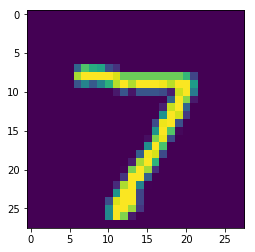

In [46]:
import matplotlib.pyplot as plt
plt.imshow(inputs[0].reshape(28,28))

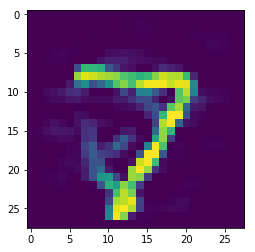

In [50]:
plt.imshow(adv[0].reshape(28,28))